In [1]:
import graphviz 
import pydotplus
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, export_graphviz
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
from typing import Dict, Tuple
from scipy import stats
from scipy.optimize import fmin_tnc
from sklearn.datasets import load_iris, load_boston, load_wine
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_log_error, median_absolute_error, r2_score 
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC, NuSVC, LinearSVC, OneClassSVM, SVR, NuSVR, LinearSVR
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 
sns.set(style="ticks")

### Подготовка данных

В качестве набора данных будем использовать Boston dataset.

In [2]:
boston = load_boston()

C:\Users\user\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np


        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alternative datasets include the California housing dataset (i

In [3]:
df_boston = pd.DataFrame(boston.data,columns=boston.feature_names)
df_boston['target'] = pd.Series(boston.target)
df_boston.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,target
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


<AxesSubplot:>

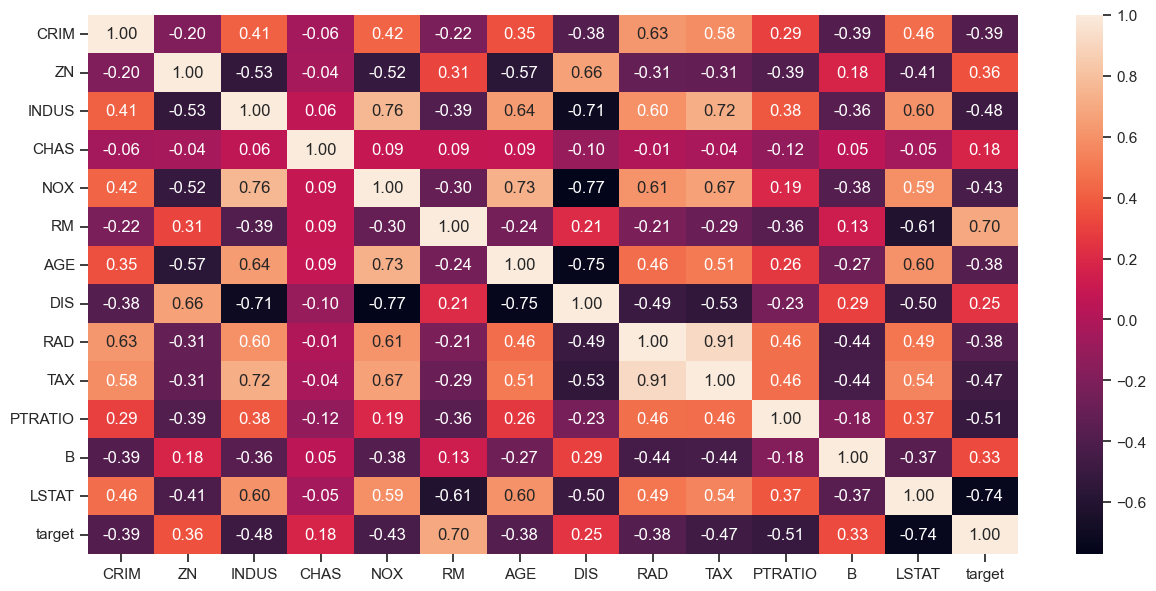

In [4]:
#Построим корреляционную матрицу
fig, ax = plt.subplots(figsize=(15,7))
sns.heatmap(df_boston.corr(method='pearson'), ax=ax, annot=True, fmt='.2f')

<AxesSubplot:xlabel='RM', ylabel='target'>

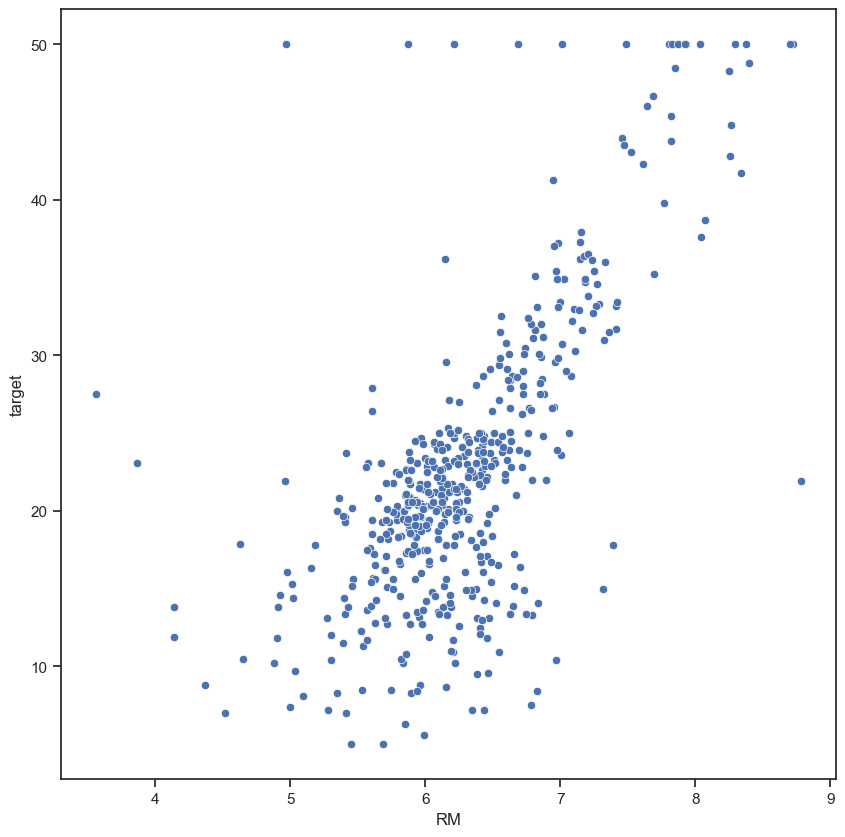

In [5]:
fig, ax = plt.subplots(figsize=(10,10)) 
sns.scatterplot(ax=ax, x='RM', y='target', data=df_boston)

Между признаком "RM" и целевым признаком "target" существует зависимость, близкая к линейной, коэффициент корреляции = 0,7

Попробуем восстановить данную линейную зависимость.

In [6]:
# Аналитическое вычисление коэффициентов регрессии
def analytic_regr_coef(x_array : np.ndarray, 
                       y_array : np.ndarray) -> Tuple[float, float]:
    x_mean = np.mean(x_array)
    y_mean = np.mean(y_array)
    var1 = np.sum([(x-x_mean)**2 for x in x_array])
    cov1 = np.sum([(x-x_mean)*(y-y_mean) for x, y in zip(x_array, y_array)])
    b1 = cov1 / var1
    b0 = y_mean - b1*x_mean
    return b0, b1

In [7]:
x_array = df_boston['RM'].values
y_array = df_boston['target'].values

In [8]:
b0, b1 = analytic_regr_coef(x_array, y_array)
b0, b1

(-34.67062077643857, 9.10210898118031)

**Аналитически вычисленные коэффициенты b0, b1 будут использоваться в дальнейшем для сравнения с другими моделями.**

In [9]:
# Вычисление значений y на основе x для регрессии
def y_regr(x_array : np.ndarray, b0: float, b1: float) -> np.ndarray:
    res = [b1*x+b0 for x in x_array]
    return res

In [10]:
y_array_regr = y_regr(x_array, b0, b1)

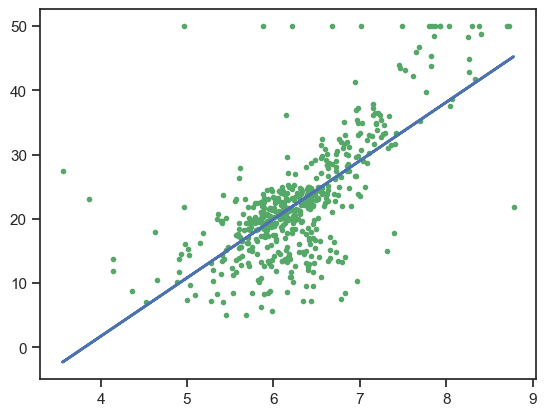

In [11]:
plt.plot(x_array, y_array, 'g.')
plt.plot(x_array, y_array_regr, 'b', linewidth=2.0)
plt.show()

### Использование класса [LinearRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html) библиотеки scikit-learn.

In [12]:
# Обучим линейную регрессию и сравним коэффициенты с рассчитанными ранее
reg1 = LinearRegression().fit(x_array.reshape(-1, 1), y_array.reshape(-1, 1))
(b1, reg1.coef_), (b0, reg1.intercept_)

((9.10210898118031, array([[9.10210898]])),
 (-34.67062077643857, array([-34.67062078])))

## [Нелинейная регрессия](https://ru.wikipedia.org/wiki/%D0%9D%D0%B5%D0%BB%D0%B8%D0%BD%D0%B5%D0%B9%D0%BD%D0%B0%D1%8F_%D1%80%D0%B5%D0%B3%D1%80%D0%B5%D1%81%D1%81%D0%B8%D1%8F)

Используется в том случае, когда данные аппроксимируются моделью, которая является более сложной, чем линейная.

In [13]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures

In [14]:
poly_model = Pipeline([('poly', PolynomialFeatures(degree=3)),
                       ('linear', LinearRegression(fit_intercept=False))])

In [15]:
poly_model.fit(x_array.reshape(-1, 1), y_array)

Pipeline(steps=[('poly', PolynomialFeatures(degree=3)),
                ('linear', LinearRegression(fit_intercept=False))])

In [16]:
poly_y_pred = poly_model.predict(x_array.reshape(-1, 1))

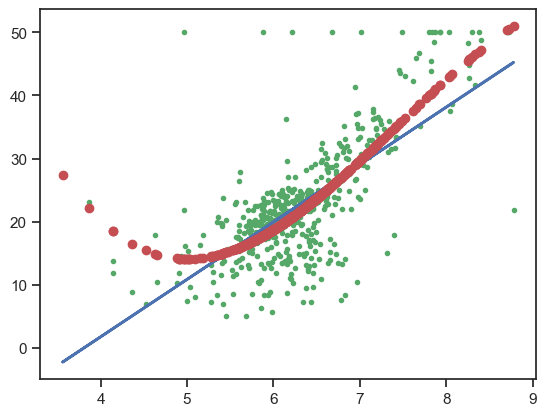

In [17]:
plt.plot(x_array, y_array, 'g.')
plt.plot(x_array, y_array_regr, 'b', linewidth=2.0)
plt.plot(x_array, poly_y_pred, 'ro')
plt.show()

In [18]:
# Степени полинома
poly_model.named_steps['linear'].coef_, poly_model.named_steps['linear'].intercept_

(array([ 241.31081379, -109.39060642,   16.49101629,   -0.74039372]), 0.0)

In [19]:
def test_poly_model(degree=3):
    poly_model = Pipeline([('poly', PolynomialFeatures(degree=degree)),
                       ('linear', LinearRegression(fit_intercept=False))])
    poly_model.fit(x_array.reshape(-1, 1), y_array)
    poly_y_pred = poly_model.predict(x_array.reshape(-1, 1))
    
    plt.plot(x_array, y_array, 'g.')
    plt.plot(x_array, y_array_regr, 'b', linewidth=2.0)
    plt.plot(x_array, poly_y_pred, 'ro')
    plt.show()
    
    print('Степени полинома - {}'.format(poly_model.named_steps['linear'].coef_))

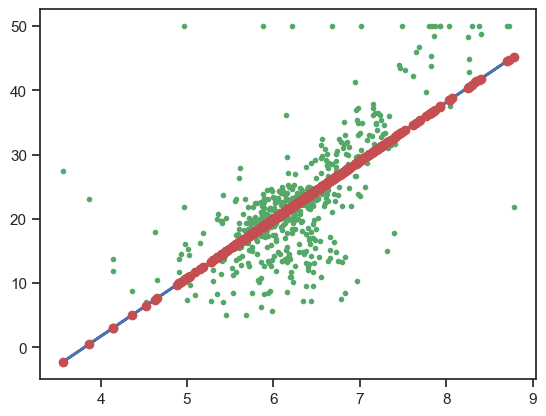

Степени полинома - [-34.67062078   9.10210898]


In [20]:
test_poly_model(degree=1)

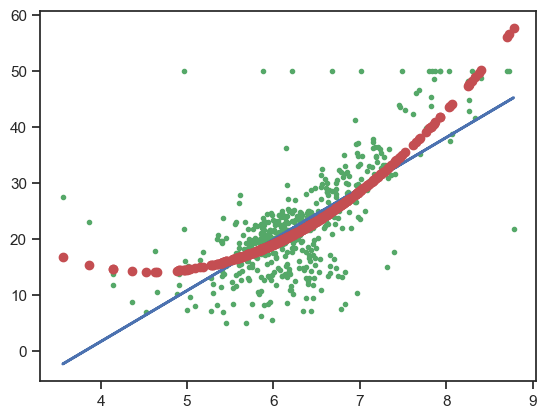

Степени полинома - [ 66.05884748 -22.64326237   2.47012384]


In [21]:
test_poly_model(degree=2)

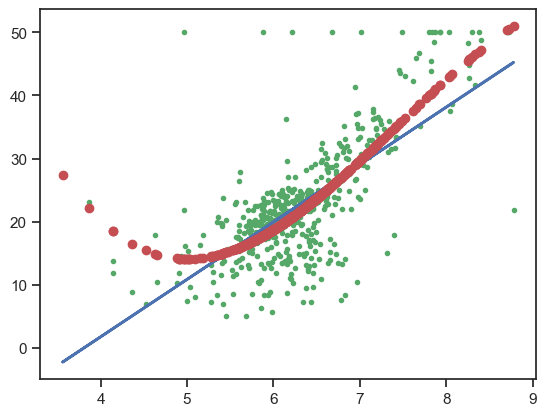

Степени полинома - [ 241.31081379 -109.39060642   16.49101629   -0.74039372]


In [22]:
test_poly_model(degree=3)

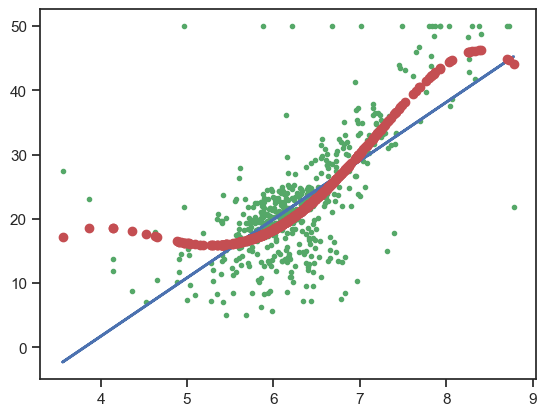

Степени полинома - [-463.48272953  371.4567309  -103.65855356   12.32148784   -0.52209014]


In [23]:
test_poly_model(degree=4)

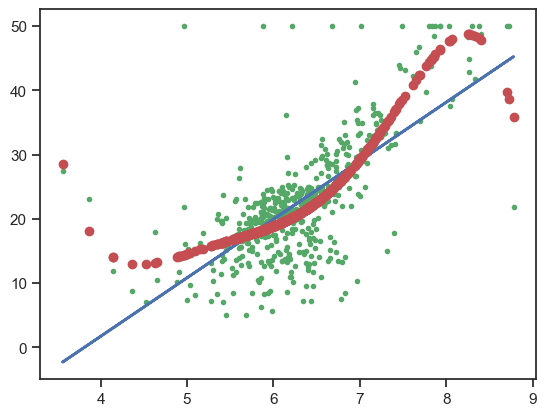

Степени полинома - [ 3.17350044e+03 -2.76788936e+03  9.57791192e+02 -1.63717675e+02
  1.38185728e+01 -4.59569815e-01]


In [24]:
test_poly_model(degree=5)

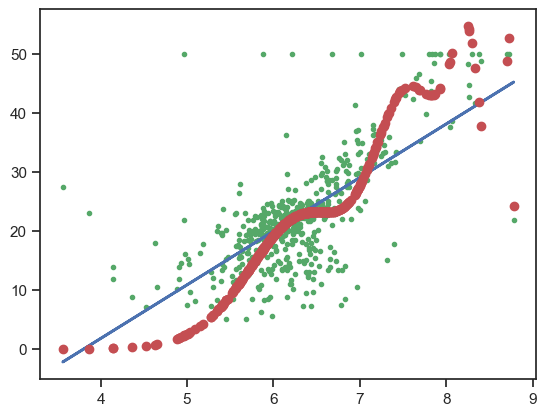

Степени полинома - [ 2.10374007e-18  1.42604969e-17 -6.05921492e-19  3.69905230e-20
  1.00301566e-20  8.60804813e-22 -1.04620426e-21 -1.92750364e-21
  2.85196051e-28  1.47448257e-27  7.55752190e-27  3.83411790e-26
  1.92188995e-25  9.49955313e-25  4.61955480e-24  2.20430099e-23
  1.02887321e-22  4.68006895e-22  2.06522975e-21  8.79146116e-21
  3.58446782e-20  1.38681562e-19  5.02826137e-19  1.67894931e-18
  5.03135675e-18  1.29868888e-17  2.68073856e-17  3.73444536e-17
  1.59043211e-17 -3.62954652e-17  1.69667408e-17 -3.93682114e-18
  5.26047340e-19 -4.13330174e-20  1.78319415e-21 -3.27188455e-23]


In [25]:
test_poly_model(degree=35)

## [Логистическая регрессия](https://ru.wikipedia.org/wiki/%D0%9B%D0%BE%D0%B3%D0%B8%D1%81%D1%82%D0%B8%D1%87%D0%B5%D1%81%D0%BA%D0%B0%D1%8F_%D1%80%D0%B5%D0%B3%D1%80%D0%B5%D1%81%D1%81%D0%B8%D1%8F) 

In [26]:
from sklearn.linear_model import LogisticRegression

In [27]:
iris = load_iris()
iris_x_ds = pd.DataFrame(data=iris['data'], columns=iris['feature_names'])
iris_x_ds_lr = iris_x_ds[['petal length (cm)', 'sepal length (cm)']]
iris_x_ds_lr['x0'] = 1
iris_x_ds_lr['target'] = iris.target
iris_x_ds_lr.head()

C:\Users\user\AppData\Local\Temp\ipykernel_5060\1655197239.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iris_x_ds_lr['x0'] = 1


,petal length (cm),sepal length (cm),x0,target
0,1.4,5.1,1,0
1,1.4,4.9,1,0
2,1.3,4.7,1,0
3,1.5,4.6,1,0
4,1.4,5.0,1,0


In [28]:
def convert_target_to_binary(array:np.ndarray, target:int) -> np.ndarray:
    # Если целевой признак совпадает с указанным, то 1 иначе 0
    res = [1 if x==target else 0 for x in array]
    return res

In [29]:
bin_iris_y = convert_target_to_binary(iris.target, 0)

In [30]:
iris_x_ds_lr['target_bin'] = bin_iris_y
iris_x_ds_lr.head()

,petal length (cm),sepal length (cm),x0,target,target_bin
0,1.4,5.1,1,0,1
1,1.4,4.9,1,0,1
2,1.3,4.7,1,0,1
3,1.5,4.6,1,0,1
4,1.4,5.0,1,0,1


In [31]:
iris_X_train, iris_X_test, iris_y_train, iris_y_test = train_test_split(
    iris_x_ds_lr[['petal length (cm)', 'sepal length (cm)']].values, 
    iris_x_ds_lr['target_bin'].values, test_size=0.5, random_state=1)

In [32]:
cl1 = LogisticRegression()

In [33]:
cl1.fit(iris_X_train, iris_y_train)

LogisticRegression()

In [34]:
pred_iris_y_test = cl1.predict(iris_X_test)
pred_iris_y_test

array([1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0,
       0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0,
       0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0,
       1, 0, 0, 0, 0, 0, 0, 1, 0], dtype=int64)

In [35]:
pred_iris_y_test_proba = cl1.predict_proba(iris_X_test)
pred_iris_y_test_proba[:10]

array([[3.03551669e-02, 9.69644833e-01],
       [6.61038870e-01, 3.38961130e-01],
       [9.91453895e-01, 8.54610520e-03],
       [3.26584185e-02, 9.67341582e-01],
       [9.99963965e-01, 3.60350727e-05],
       [9.95340342e-01, 4.65965828e-03],
       [9.98647747e-01, 1.35225325e-03],
       [1.15108534e-01, 8.84891466e-01],
       [4.98014444e-02, 9.50198556e-01],
       [9.99690875e-01, 3.09124539e-04]])

In [36]:
# Вероятность принадлежности к 0 классу
[round(x, 4) for x in pred_iris_y_test_proba[:10,0]]

[0.0304, 0.661, 0.9915, 0.0327, 1.0, 0.9953, 0.9986, 0.1151, 0.0498, 0.9997]

In [37]:
# Вероятность принадлежности к 1 классу
[round(x, 4) for x in pred_iris_y_test_proba[:10,1]]

[0.9696, 0.339, 0.0085, 0.9673, 0.0, 0.0047, 0.0014, 0.8849, 0.9502, 0.0003]

In [38]:
# Сумма вероятностей равна 1
pred_iris_y_test_proba[:10,0] + pred_iris_y_test_proba[:10,1]

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [39]:
accuracy_score(iris_y_test, pred_iris_y_test)

1.0

In [40]:
def accuracy_score_for_classes(
    y_true: np.ndarray, 
    y_pred: np.ndarray) -> Dict[int, float]:
    """
    Вычисление метрики accuracy для каждого класса
    y_true - истинные значения классов
    y_pred - предсказанные значения классов
    Возвращает словарь: ключ - метка класса, 
    значение - Accuracy для данного класса
    """
    # Для удобства фильтрации сформируем Pandas DataFrame 
    d = {'t': y_true, 'p': y_pred}
    df = pd.DataFrame(data=d)
    # Метки классов
    classes = np.unique(y_true)
    # Результирующий словарь
    res = dict()
    # Перебор меток классов
    for c in classes:
        # отфильтруем данные, которые соответствуют 
        # текущей метке класса в истинных значениях
        temp_data_flt = df[df['t']==c]
        # расчет accuracy для заданной метки класса
        temp_acc = accuracy_score(
            temp_data_flt['t'].values, 
            temp_data_flt['p'].values)
        # сохранение результата в словарь
        res[c] = temp_acc
    return res

def print_accuracy_score_for_classes(
    y_true: np.ndarray, 
    y_pred: np.ndarray):
    """
    Вывод метрики accuracy для каждого класса
    """
    accs = accuracy_score_for_classes(y_true, y_pred)
    if len(accs)>0:
        print('Метка \t Accuracy')
    for i in accs:
        print('{} \t {}'.format(i, accs[i]))

In [41]:
print_accuracy_score_for_classes(iris_y_test, pred_iris_y_test)

Метка 	 Accuracy
0 	 1.0
1 	 1.0


## SVM

In [42]:
def plot_regr(clf):
    title = clf.__repr__
    clf.fit(x_array.reshape(-1, 1), y_array)
    boston_y_pred = clf.predict(x_array.reshape(-1, 1))
    fig, ax = plt.subplots(figsize=(5,5))
    ax.set_title(title)
    ax.plot(x_array, y_array, 'b.')
    ax.plot(x_array, boston_y_pred, 'ro')
    plt.show()

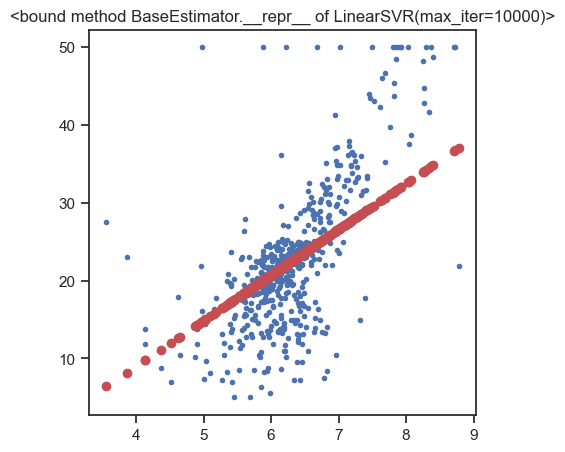

In [43]:
plot_regr(LinearSVR(C=1.0, max_iter=10000))

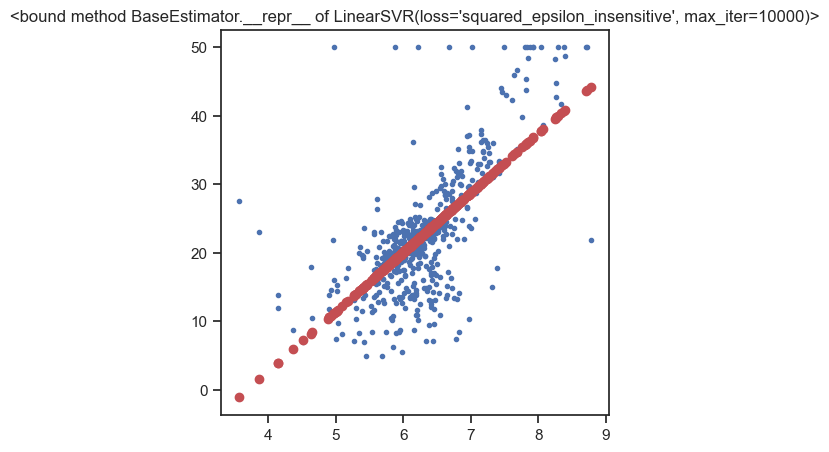

In [44]:
plot_regr(LinearSVR(C=1.0, loss='squared_epsilon_insensitive', max_iter=10000))

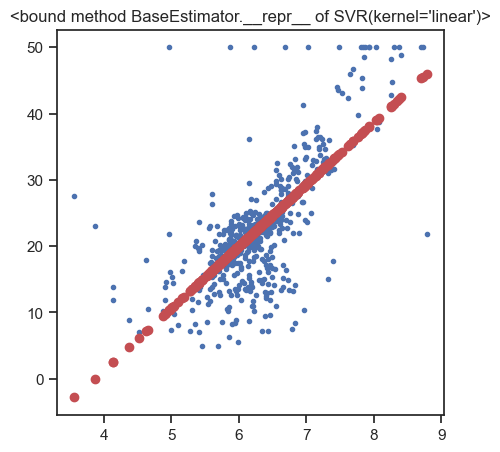

In [45]:
plot_regr(SVR(kernel='linear', C=1.0))

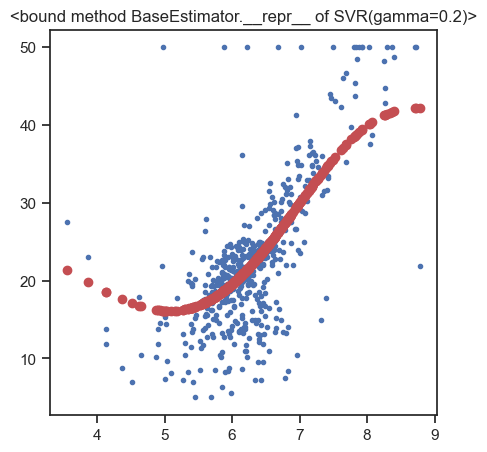

In [46]:
plot_regr(SVR(kernel='rbf', gamma=0.2, C=1.0))

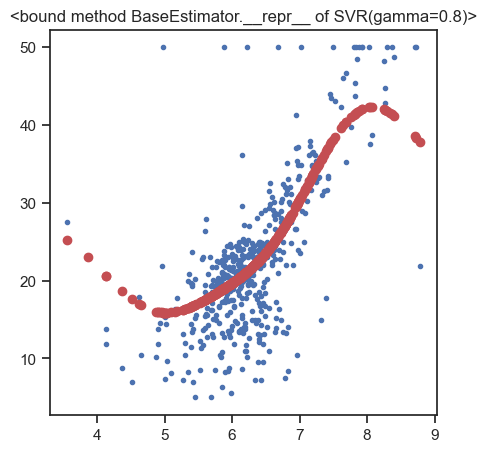

In [47]:
plot_regr(SVR(kernel='rbf', gamma=0.8, C=1.0))

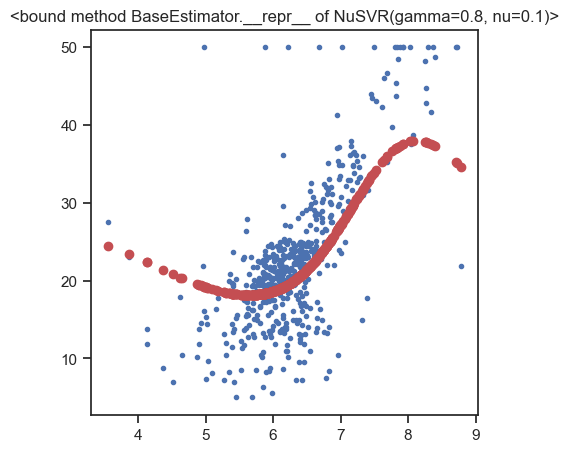

In [48]:
plot_regr(NuSVR(kernel='rbf', gamma=0.8, nu=0.1, C=1.0))

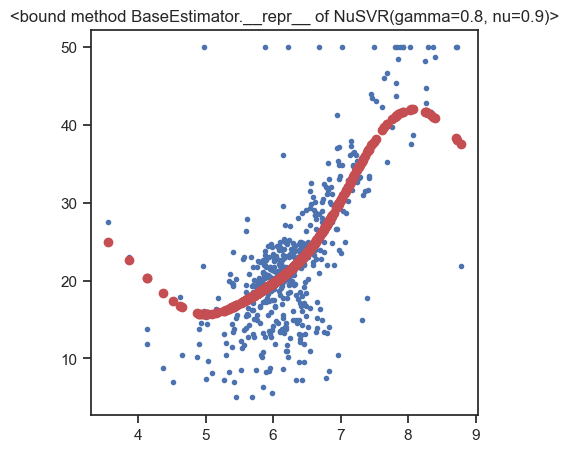

In [49]:
plot_regr(NuSVR(kernel='rbf', gamma=0.8, nu=0.9, C=1.0))

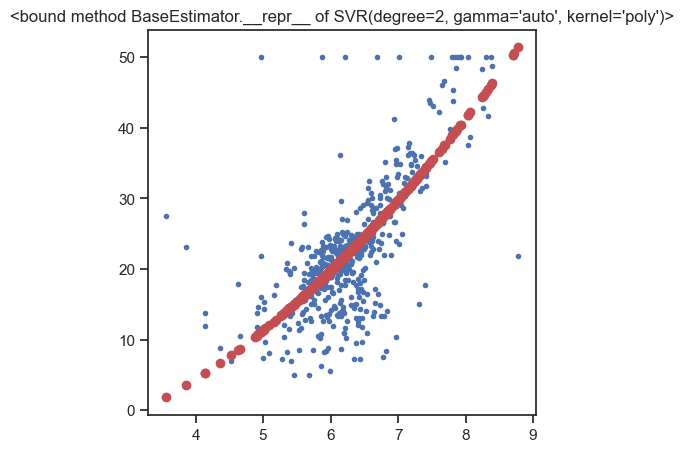

In [50]:
plot_regr(SVR(kernel='poly', degree=2, gamma='auto', C=1.0))

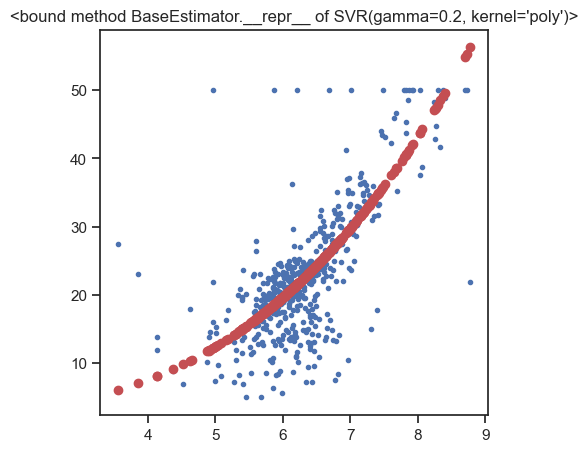

In [51]:
plot_regr(SVR(kernel='poly', degree=3, gamma=0.2, C=1.0))

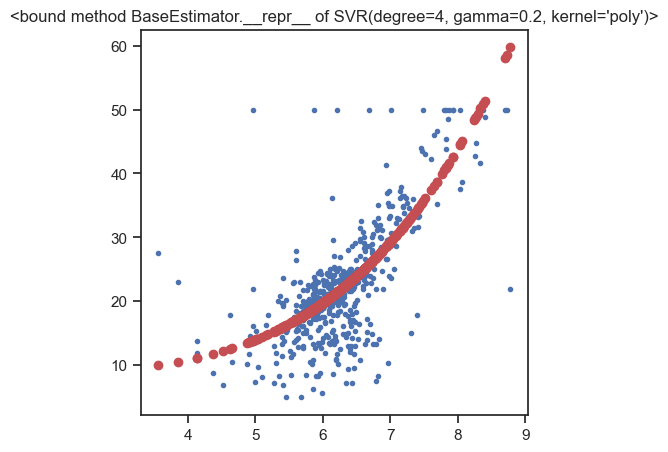

In [52]:
plot_regr(SVR(kernel='poly', degree=4, gamma=0.2, C=1.0))

In [53]:
boston_x_columns = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT']
boston_X_train_1, boston_X_test_1, boston_y_train_1, boston_y_test_1 = train_test_split(
    df_boston[boston_x_columns], df_boston['target'], test_size=0.2, random_state=1)

boston_X_train_1.shape, boston_X_test_1.shape

((404, 13), (102, 13))

In [54]:
svr_1 = SVR()
svr_1.fit(boston_X_train_1, boston_y_train_1)

SVR()

In [55]:
boston_y_pred_1 = svr_1.predict(boston_X_test_1)

In [56]:
mean_absolute_error(boston_y_test_1, boston_y_pred_1), mean_squared_error(boston_y_test_1, boston_y_pred_1)

(5.521848058473931, 80.88313574924172)

## Дерево решений

In [57]:
# Используем датасеты для классификации
iris = load_iris()
wine = load_wine()
iris_x_ds = pd.DataFrame(data=iris['data'], columns=iris['feature_names'])
iris_x_ds.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


In [58]:
def plot_tree_classification(title_param, ds):
    """
    Построение деревьев и вывод графиков для заданного датасета
    """
    
    n_classes = len(np.unique(ds.target))
    plot_colors = "ryb"
    plot_step = 0.02
    
    for pairidx, pair in enumerate([[0, 1], [0, 2], [0, 3],
                                    [1, 2], [1, 3], [2, 3]]):
        # We only take the two corresponding features
        X = ds.data[:, pair]
        y = ds.target

        # Train
        clf = DecisionTreeClassifier(random_state=1).fit(X, y)

        plt.title(title_param)

        x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
        y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
        xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                             np.arange(y_min, y_max, plot_step))
        plt.tight_layout(h_pad=0.5, w_pad=0.5, pad=2.5)

        Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)
        cs = plt.contourf(xx, yy, Z, cmap=plt.cm.RdYlBu)

        plt.xlabel(ds.feature_names[pair[0]])
        plt.ylabel(ds.feature_names[pair[1]])

        # Plot the training points
        for i, color in zip(range(n_classes), plot_colors):
            idx = np.where(y == i)
            plt.scatter(X[idx, 0], X[idx, 1], c=color, label=ds.target_names[i],
                        cmap=plt.cm.RdYlBu, edgecolor='black', s=15)

        plt.show()    

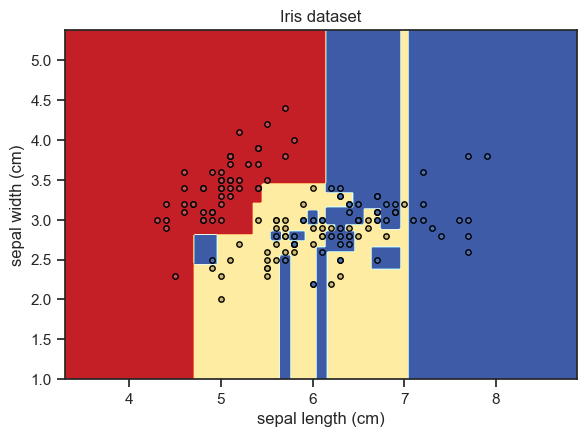

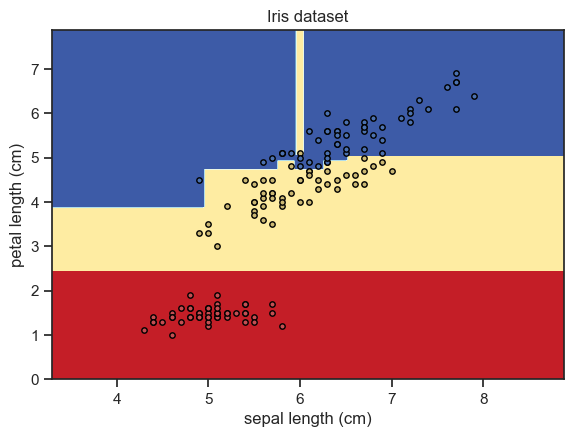

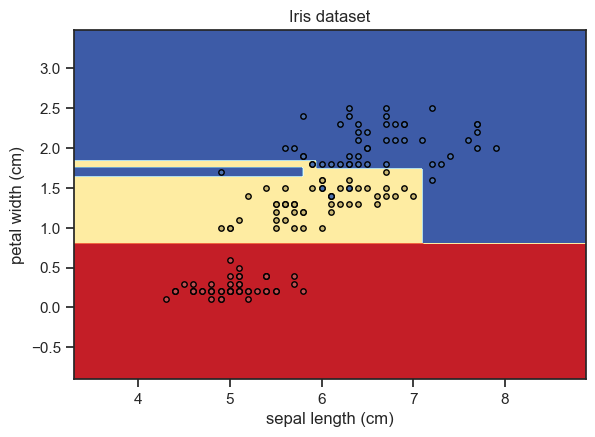

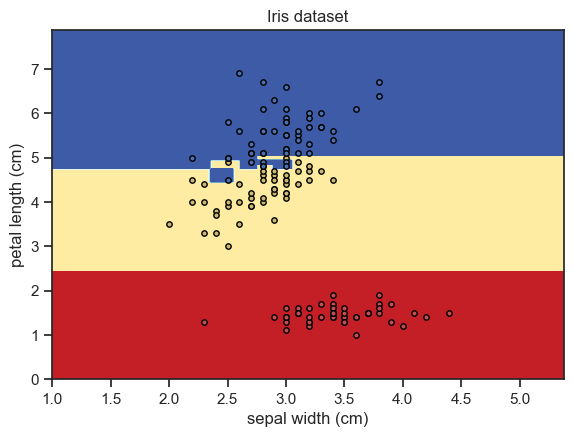

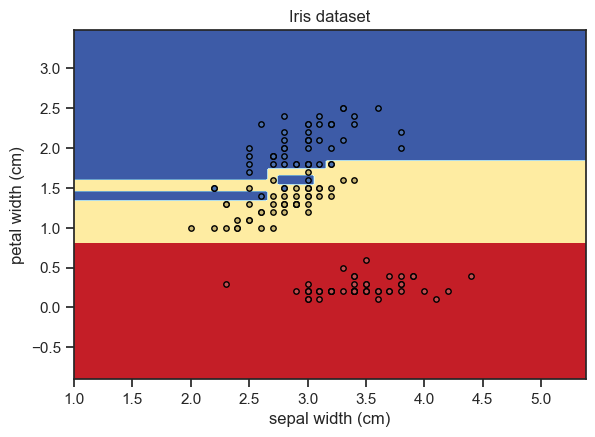

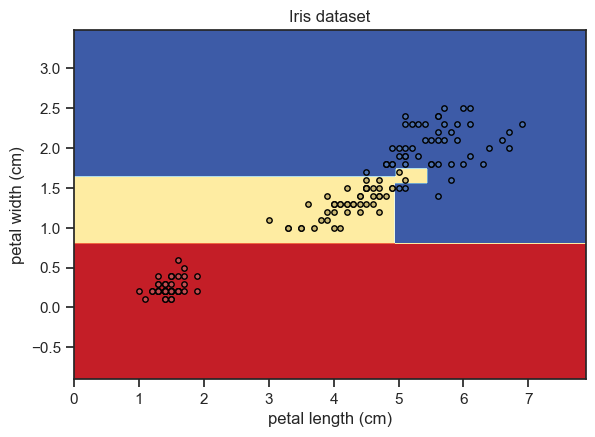

In [59]:
plot_tree_classification('Iris dataset', iris)

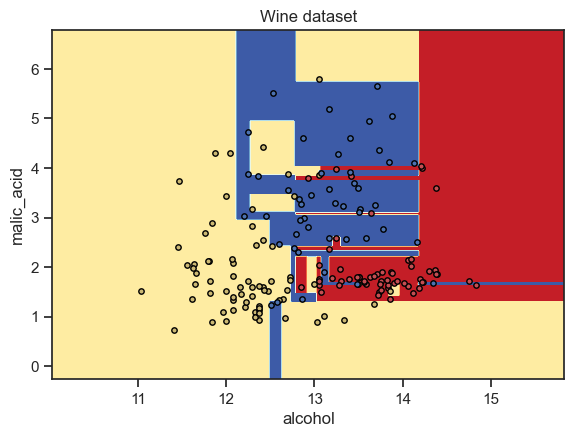

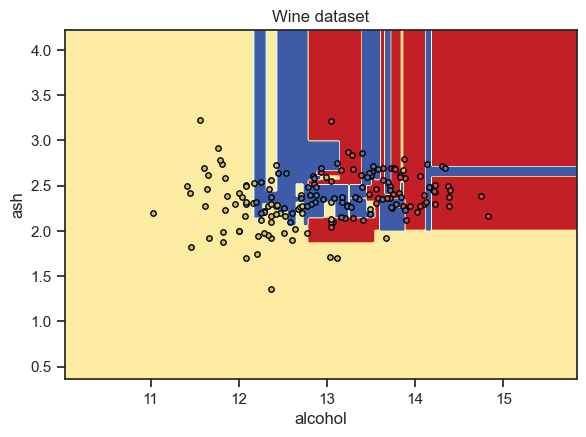

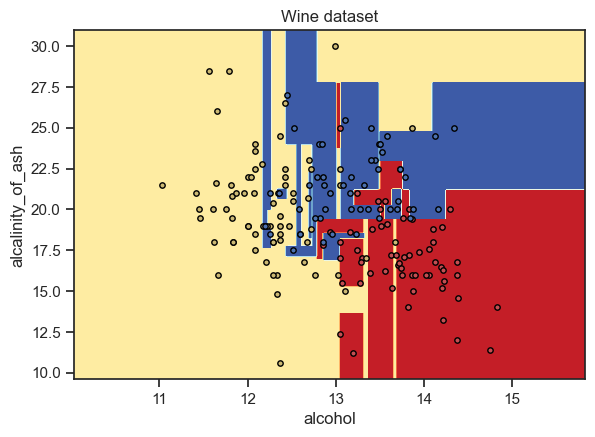

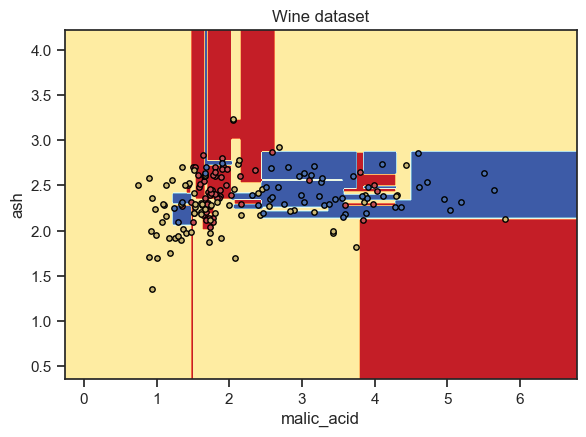

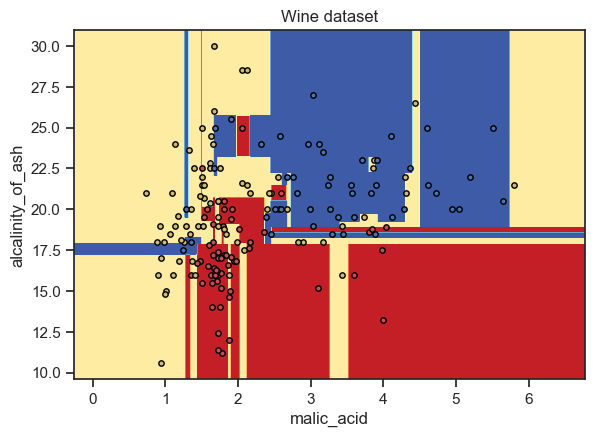

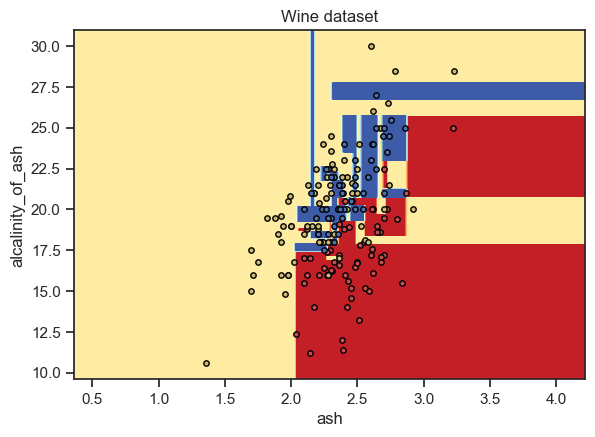

In [60]:
plot_tree_classification('Wine dataset', wine)

In [61]:
# Обучим дерево на всех признаках iris
iris_tree_cl = DecisionTreeClassifier(random_state=1)
iris_tree_cl.fit(iris_x_ds, iris.target)
iris_tree_cl

DecisionTreeClassifier(random_state=1)

## Вывод правил дерева в текстовом виде

In [62]:
from IPython.core.display import HTML
from sklearn.tree import export_text
tree_rules = export_text(iris_tree_cl, feature_names=list(iris_x_ds.columns))
HTML('<pre>' + tree_rules + '</pre>')

## Пример визуализации дерева

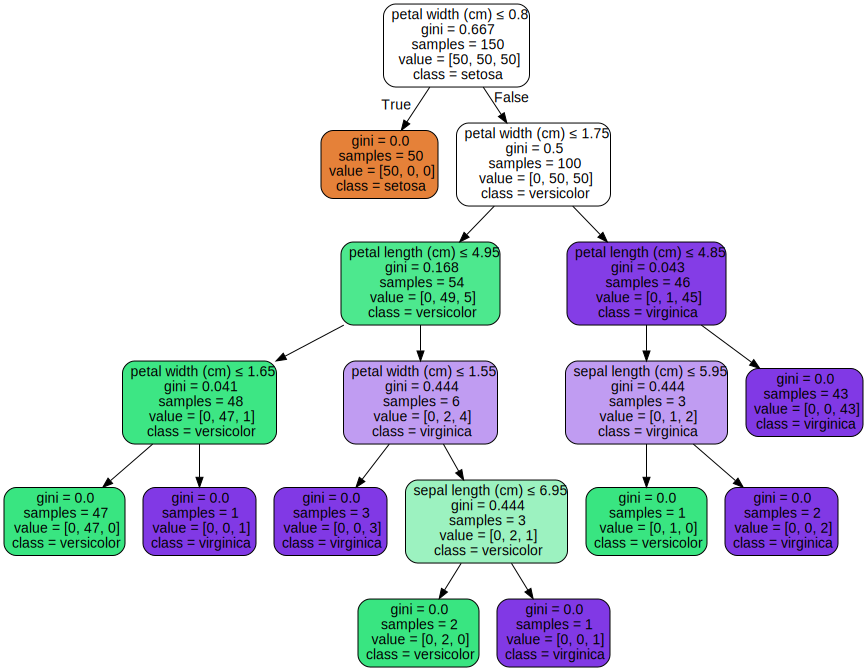

In [63]:
dot_data = export_graphviz(iris_tree_cl, out_file=None, 
                           feature_names=iris.feature_names, 
                           class_names=iris.target_names, 
                           filled=True, rounded=True, special_characters=True)  
graph = graphviz.Source(dot_data)  
graph

## Важность признаков
С помощью свойства feature_importances_ можно получить значение важности признаков.

Вычисление важности признаков основано на том, какое количество раз признак встречается в условиях дерева. Чем чаще встречается признак, тем более он важен.

In [64]:
# Важность признаков
list(zip(iris_x_ds.columns.values, iris_tree_cl.feature_importances_))

[('sepal length (cm)', 0.026666666666666658),
 ('sepal width (cm)', 0.0),
 ('petal length (cm)', 0.05072262479871173),
 ('petal width (cm)', 0.9226107085346216)]

In [65]:
# Важность признаков в сумме дает единицу
sum(iris_tree_cl.feature_importances_)

1.0

In [66]:
from operator import itemgetter

def draw_feature_importances(tree_model, X_dataset, figsize=(18,5)):
    """
    Вывод важности признаков в виде графика
    """
    # Сортировка значений важности признаков по убыванию
    list_to_sort = list(zip(X_dataset.columns.values, tree_model.feature_importances_))
    sorted_list = sorted(list_to_sort, key=itemgetter(1), reverse = True)
    # Названия признаков
    labels = [x for x,_ in sorted_list]
    # Важности признаков
    data = [x for _,x in sorted_list]
    # Вывод графика
    fig, ax = plt.subplots(figsize=figsize)
    ind = np.arange(len(labels))
    plt.bar(ind, data)
    plt.xticks(ind, labels, rotation='vertical')
    # Вывод значений
    for a,b in zip(ind, data):
        plt.text(a-0.05, b+0.01, str(round(b,3)))
    plt.show()
    return labels, data

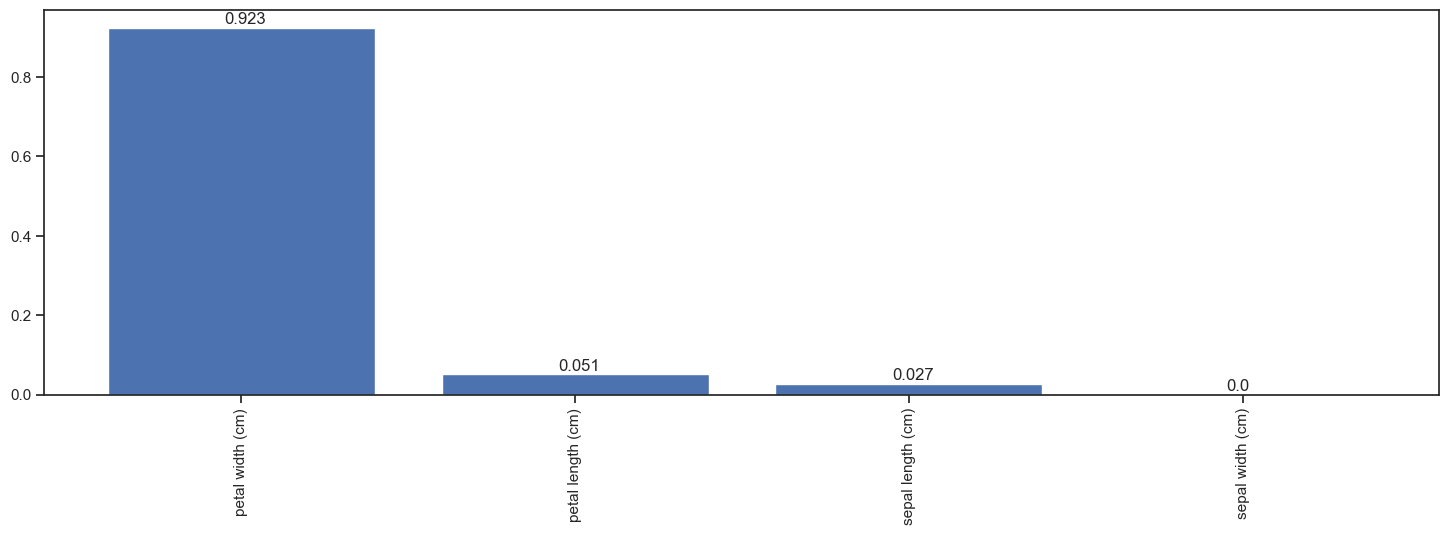

In [67]:
iris_tree_cl_fl, iris_tree_cl_fd = draw_feature_importances(iris_tree_cl, iris_x_ds)

In [68]:
# Список признаков, отсортированный на основе важности, и значения важности
iris_tree_cl_fl, iris_tree_cl_fd

(['petal width (cm)',
  'petal length (cm)',
  'sepal length (cm)',
  'sepal width (cm)'],
 [0.9226107085346216, 0.05072262479871173, 0.026666666666666658, 0.0])